In [125]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [126]:
# import the raw dataset
df = pd.read_csv("rawdata.csv")

In [127]:
np.mean(df.groupby("Date").size())

39.420548819400125

In [128]:
# calculate the label
df["next_day"] = df["Close"].shift(-1)

df["target"] = (df["next_day"] > df["Close"]).astype(int)

def remove_last_row(group):
    return group.iloc[:-1]

df = df.groupby("ETFs_index").apply(remove_last_row).reset_index(drop=True)

df

,Date,Open,High,Low,Close,Volume,OpenInt,ETFs_index,next_day,target
0,2007-10-30,49.7000,49.7000,49.7000,49.7000,100,0,0,50.0000,1
1,2007-10-31,49.6800,50.0000,49.6800,50.0000,4700,0,0,49.1300,0
2,2007-11-01,49.3600,49.3600,49.1000,49.1300,19100,0,0,49.0500,0
3,2007-11-02,49.2500,49.2500,49.0500,49.0500,4300,0,0,48.9400,0
4,2007-11-05,48.9400,48.9400,48.9400,48.9400,100,0,0,49.6600,1
...,...,...,...,...,...,...,...,...,...,...
185211,2017-11-03,26.1700,26.2100,26.1700,26.1832,1998,0,99,26.1800,0
185212,2017-11-06,26.1900,26.2300,26.1800,26.1800,5594,0,99,26.1766,0
185213,2017-11-07,26.2159,26.2159,26.1757,26.1766,5551,0,99,26.1701,0
185214,2017-11-08,26.1700,26.1800,26.1500,26.1701,127275,0,99,26.1900,1


In [129]:
# sort the data and remove irrelevant features
df = df.sort_values(by="Date")

df = df.drop("OpenInt", axis=1)

# df = df.drop("ETFs_index", axis=1)

df = df.drop("next_day", axis=1)

df.set_index("Date", inplace=True)

df

,Open,High,Low,Close,Volume,ETFs_index,target
Date,,,,,,,
1999-03-10,45.7220,45.7500,44.9670,45.6650,11700414,41,1
1999-03-11,45.9940,46.2600,44.9880,45.8800,21670048,41,0
1999-03-12,45.7210,45.7490,44.4060,44.7700,19553768,41,1
1999-03-15,45.1010,46.1030,44.6250,46.0520,14245348,41,1
1999-03-16,46.2530,46.6430,45.7490,46.4470,10971066,41,0
...,...,...,...,...,...,...,...
2017-11-09,25.2200,25.3200,25.1550,25.2900,4516551,89,1
2017-11-09,24.2700,24.3100,24.1168,24.3000,93531,6,0
2017-11-09,50.2329,50.3031,49.9600,50.3031,6267,12,0


In [130]:
# feature extraction
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = df.rolling(horizon * 39).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    df[ratio_column] = df["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    df[trend_column] = df.shift(1).rolling(horizon * 39).sum()["target"]
    
    new_predictors+= [ratio_column, trend_column]
    
df = df.dropna()

df.to_csv("feature_extracted.csv", index=False)

df

,Open,High,Low,Close,Volume,ETFs_index,target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
2010-08-06,15.8500,16.0500,15.5500,15.6000,11405,78,0,0.451045,41.0,0.433488,94.0,0.435645,1232.0,0.410164,5057.0,0.421132,19917.0
2010-08-06,25.7300,26.0900,25.7300,26.0900,464,14,0,0.761027,40.0,0.724536,94.0,0.730506,1232.0,0.685969,5056.0,0.704326,19916.0
2010-08-06,13.6480,13.6720,13.4780,13.5500,34975,18,1,0.394723,40.0,0.379756,94.0,0.379407,1232.0,0.356258,5055.0,0.365804,19916.0
2010-08-06,21.5090,21.5460,21.2640,21.5460,112463,85,1,0.629987,41.0,0.605272,95.0,0.603240,1233.0,0.566511,5055.0,0.581679,19916.0
2010-08-06,22.3410,22.3480,22.1670,22.1670,770,46,0,0.656987,42.0,0.621724,95.0,0.620620,1234.0,0.582856,5055.0,0.598454,19916.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-09,25.2200,25.3200,25.1550,25.2900,4516551,89,1,0.456379,29.0,0.472916,66.0,0.487958,1188.0,0.503038,5305.0,0.535405,20609.0
2017-11-09,24.2700,24.3100,24.1168,24.3000,93531,6,0,0.447430,30.0,0.454890,66.0,0.468795,1188.0,0.483361,5305.0,0.514443,20609.0
2017-11-09,50.2329,50.3031,49.9600,50.3031,6267,12,0,0.928465,30.0,0.939920,65.0,0.970268,1187.0,1.000553,5304.0,1.065006,20608.0


Feature selection

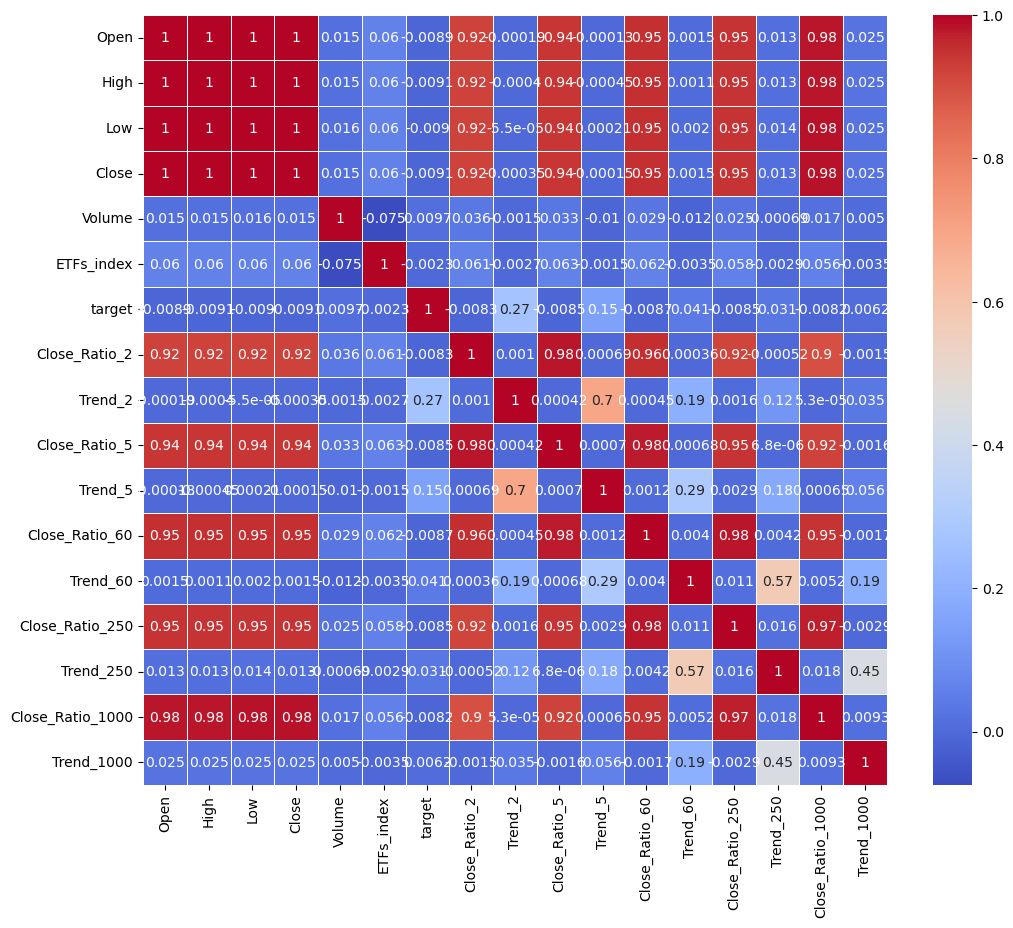

In [131]:
# analyze current correlation
corr_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.show()

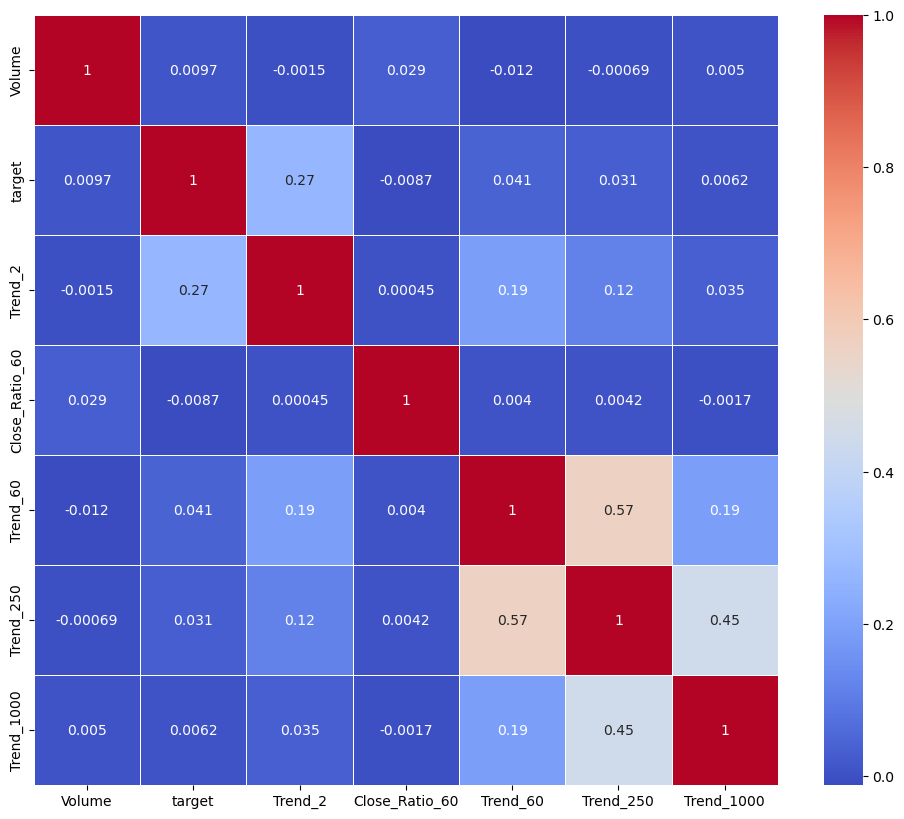

In [132]:
# check correlation heatmap after selecting certain features
selected_features = ['Volume',
       'target', 'Trend_2',
       'Close_Ratio_60', 'Trend_60', 'Trend_250',
       'Trend_1000']

partial_corr_matrix = df[selected_features].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(partial_corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.show()

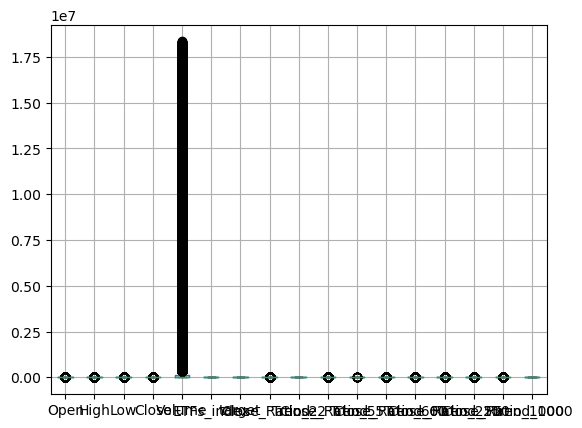

In [133]:
# handle outliers
cols = ['Volume']

z_scores = stats.zscore(df[cols])
abs_z_scores = abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
df = df[filtered_entries]

box_plots = df.boxplot()

In [134]:
# check null values
print(df.isnull().sum())

Open                0
High                0
Low                 0
Close               0
Volume              0
ETFs_index          0
target              0
Close_Ratio_2       0
Trend_2             0
Close_Ratio_5       0
Trend_5             0
Close_Ratio_60      0
Trend_60            0
Close_Ratio_250     0
Trend_250           0
Close_Ratio_1000    0
Trend_1000          0
dtype: int64


In [135]:
# output datasets
features = ['Volume', 'Trend_2', 'ETFs_index',
       'Close_Ratio_60', 'Trend_60', 'Trend_250',
       'Trend_1000']

training_size = int(len(df) * 0.8)
test_size = df.shape[0] - training_size

xTrain = df[features].iloc[:training_size]
xTest = df[features].iloc[-1 * test_size:]

yTrain_discrete = df["target"].iloc[:training_size]
yTest_discrete = df["target"].iloc[-1 * test_size:]

scalar1 = StandardScaler()

xTrain = scalar1.fit_transform(xTrain)
xTest = scalar1.transform(xTest)

pd.DataFrame(xTrain, columns=features).to_csv("newData/xTrain.csv", index=False)
pd.DataFrame(xTest, columns=features).to_csv("newData/xTest.csv", index=False)

pd.DataFrame(yTrain_discrete).to_csv("newData/yTrain_discrete.csv", index=False)
pd.DataFrame(yTest_discrete).to_csv("newData/yTest_discrete.csv", index=False)